In [1]:
import numpy as np                  # for numerical operations, arrays, math (mean, variance, log, exp)
import pandas as pd                 # (optional) for handling tabular data if needed later

from sklearn.model_selection import train_test_split  
# splits dataset into training data and testing data

from sklearn.metrics import accuracy_score  
# computes how many predictions are correct

from sklearn.metrics import confusion_matrix  
# shows how many spam / non-spam emails were classified correctly or wrongly

from sklearn.metrics import classification_report  
# gives precision, recall, and F1-score for spam and non-spam


In [5]:
# Load the Spambase dataset from the uploaded file
data = np.loadtxt("spambase/spambase.data", delimiter=",")

# Reads the CSV-like file and converts it into a NumPy array

# Separate the input features (X) and the class labels (y)
X = data[:, :-1]     
# Takes all rows, and all columns EXCEPT the last → these are the 57 email features

y = data[:, -1]      
# Takes all rows, and ONLY the last column → this is the label (1 = spam, 0 = not spam)


In [6]:
# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y,                  # X = features, y = labels
    test_size=0.2,         # 20% of the data will be used for testing
    random_state=42,       # ensures we get the same split every time (reproducibility)
    stratify=y             # keeps the same spam / non-spam ratio in both sets
)


In [18]:
class NaiveBayes:

    # This function trains (learns) from the data
    def fit(self, X, y):
        n_samples, n_features = X.shape      # number of rows and columns in X
        self._classes = np.unique(y)         # finds unique class labels (0 and 1)
        n_classes = len(self._classes)       # number of classes (2: spam, not spam)

        # Create empty tables for statistics
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)   # mean per class per feature
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)    # variance per class per feature
        self._priors = np.zeros(n_classes, dtype=np.float64)              # prior probability per class

        # Compute statistics for each class
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]                   # select rows belonging to class c
            self._mean[idx, :] = X_c.mean(axis=0)   # average of each feature
            self._var[idx, :] = X_c.var(axis=0) + 1e-9   # variance (+ small value to avoid divide by zero)
            self._priors[idx] = X_c.shape[0] / float(n_samples)  # probability of the class


    # This function predicts class labels for many samples
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]   # predict one by one
        return np.array(y_pred)


    # This function predicts the class for one sample
    def _predict(self, x):
        posteriors = []                         # stores probability score per class

        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])   # log of prior probability
            likelihood = np.sum(np.log(self._pdf(idx, x)))   # log of likelihoods
            posterior = prior + likelihood     # Bayes theorem (log form)
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]  # return class with highest score


    # Gaussian probability density function
    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]

        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)

        pdf = numerator / denominator

    # Prevent log(0) by replacing zeros with a very small number
        pdf = np.where(pdf == 0, 1e-9, pdf)

        return pdf
    


In [19]:
# Create an instance (object) of our Naive Bayes classifier
nb = NaiveBayes()  
# This makes a new NaiveBayes model using the class we coded from scratch

# Train (fit) the model using the training data
nb.fit(X_train, y_train)  
# The model learns:
# 1) the mean of each feature for spam and non-spam
# 2) the variance of each feature for spam and non-spam
# 3) the prior probability of spam and non-spam


In [20]:
# Use the trained model to predict labels for the test data
y_pred = nb.predict(X_test)  
# For each email in X_test:
# 1) compute probability of being non-spam (0)
# 2) compute probability of being spam (1)
# 3) choose the class with the higher probability


In [22]:
# Train again (so the model uses the updated _pdf behavior)
nb = NaiveBayes()                 # create a fresh model object
nb.fit(X_train, y_train)          # learn mean, variance, and priors from training set

# Predict again
y_pred = nb.predict(X_test)       # predict spam (1) or not spam (0) for test emails

# Evaluate again
acc = accuracy_score(y_test, y_pred)     # overall correctness
cm = confusion_matrix(y_test, y_pred)    # TN, FP, FN, TP table

print("Accuracy:", acc)                  # show accuracy score
print("\nConfusion Matrix:\n", cm)       # show confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # precision/recall/F1



Accuracy: 0.739413680781759

Confusion Matrix:
 [[334 224]
 [ 16 347]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.60      0.74       558
         1.0       0.61      0.96      0.74       363

    accuracy                           0.74       921
   macro avg       0.78      0.78      0.74       921
weighted avg       0.82      0.74      0.74       921



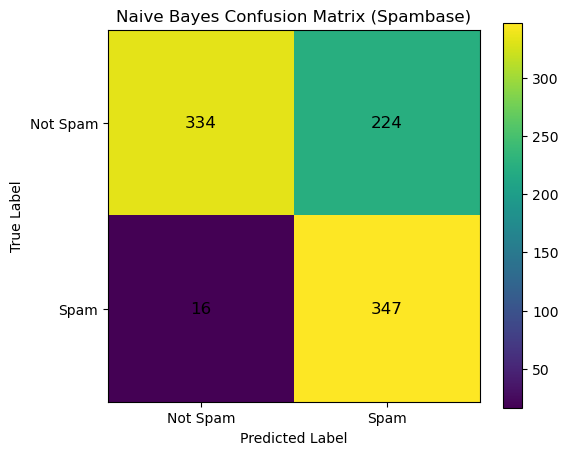

In [24]:
import matplotlib.pyplot as plt                    # plotting library (for graphs/figures)

cm = confusion_matrix(y_test, y_pred)              # build confusion matrix using true vs predicted labels

plt.figure(figsize=(6, 5))                         # create a new figure window sized 6x5 inches
plt.imshow(cm)                                     # display the confusion matrix as an image (grid)
plt.title("Naive Bayes Confusion Matrix (Spambase)")# add a title at the top
plt.colorbar()                                     # add a color scale legend (darker = larger value)

plt.xticks([0, 1], ["Not Spam", "Spam"])           # label x-axis ticks (predicted classes)
plt.yticks([0, 1], ["Not Spam", "Spam"])           # label y-axis ticks (true classes)

for i in range(2):                                 # loop over rows (0 and 1)
    for j in range(2):                             # loop over columns (0 and 1)
        plt.text(j, i, cm[i, j],                   # write the value cm[i,j] inside each cell
                 ha="center", va="center", fontsize=12)  # center the text and set font size

plt.xlabel("Predicted Label")                      # label for x-axis (model output)
plt.ylabel("True Label")                           # label for y-axis (actual class)

plt.show()                                         # display the plot on screen



| Position     | Meaning                                           |
| ------------ | ------------------------------------------------- |
| Top-left     | Not spam correctly classified                     |
| Top-right    | Not spam wrongly flagged as spam (False Positive) |
| Bottom-left  | Spam missed (False Negative)                      |
| Bottom-right | Spam correctly detected                           |
